In [13]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

You should consider upgrading via the 'C:\Users\HP\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

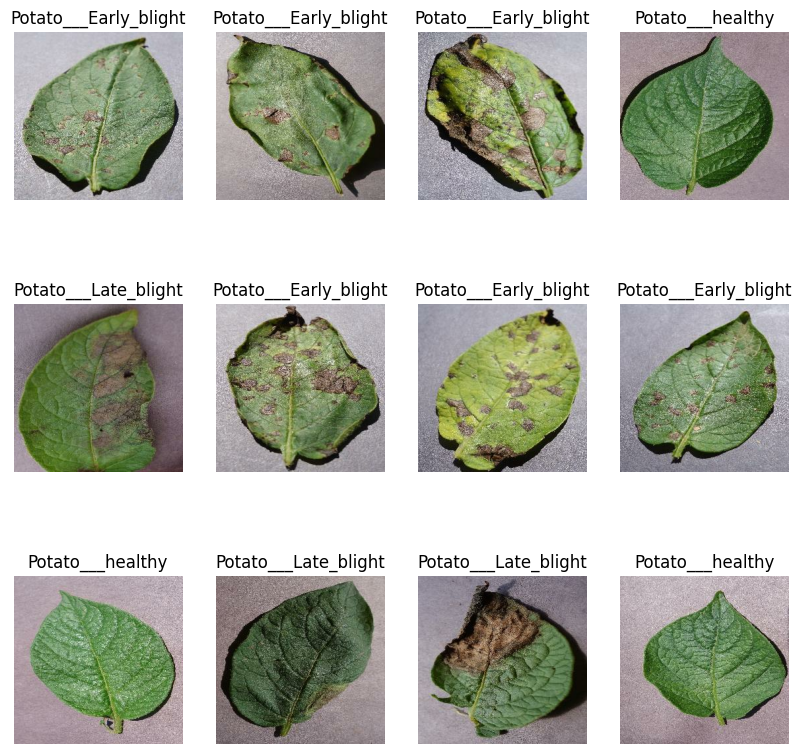

In [12]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [14]:
# Performing train-test split
train_split = 0.8
train_len = np.floor(len(dataset)*train_split)
train_ds = dataset.take(train_len)
test_ds = dataset.skip(train_len)

In [16]:
def get_data_split(ds,train_split=0.8, val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = np.floor(len(ds)*train_split)
    val_size = np.floor(len(ds)*val_split)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [17]:
train_ds,val_ds,test_ds = get_data_split(dataset)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([ layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
                    ])

In [20]:
data_augmentation = tf.keras.Sequential([ layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                         layers.experimental.preprocessing.RandomRotation(0.2)
                                        ])

In [24]:

input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    ])

model.build(input_shape=input_shape)


In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [26]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_ds,epochs=50,batch_size = BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 139s 2s/step - loss: 0.9062 - accuracy: 0.4913 - val_loss: 0.8562 - val_accuracy: 0.5312
Epoch 2/50
54/54 [==============================] - 120s 2s/step - loss: 0.6436 - accuracy: 0.6927 - val_loss: 0.4401 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 110s 2s/step - loss: 0.3471 - accuracy: 0.8547 - val_loss: 0.2842 - val_accuracy: 0.8958
Epoch 4/50
54/54 [==============================] - 122s 2s/step - loss: 0.2713 - accuracy: 0.8895 - val_loss: 0.2276 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 116s 2s/step - loss: 0.2389 - accuracy: 0.9051 - val_loss: 0.1796 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 116s 2s/step - loss: 0.2013 - accuracy: 0.9207 - val_loss: 0.2415 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 112s 2s/step - loss: 0.1507 - accuracy: 0.9398 - val_loss: 0.1114 - val_accuracy: 0.9688
Epoch 8/50
54

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Accuracy')

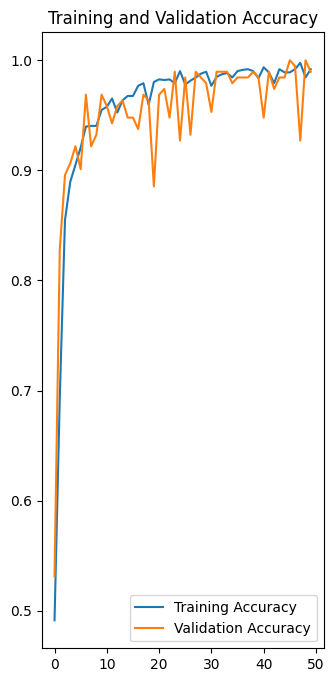

In [30]:
EPOCHS = 50
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [31]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    return predicted_class,confidence
    

1/1 [==============================] - 0s 54ms/step


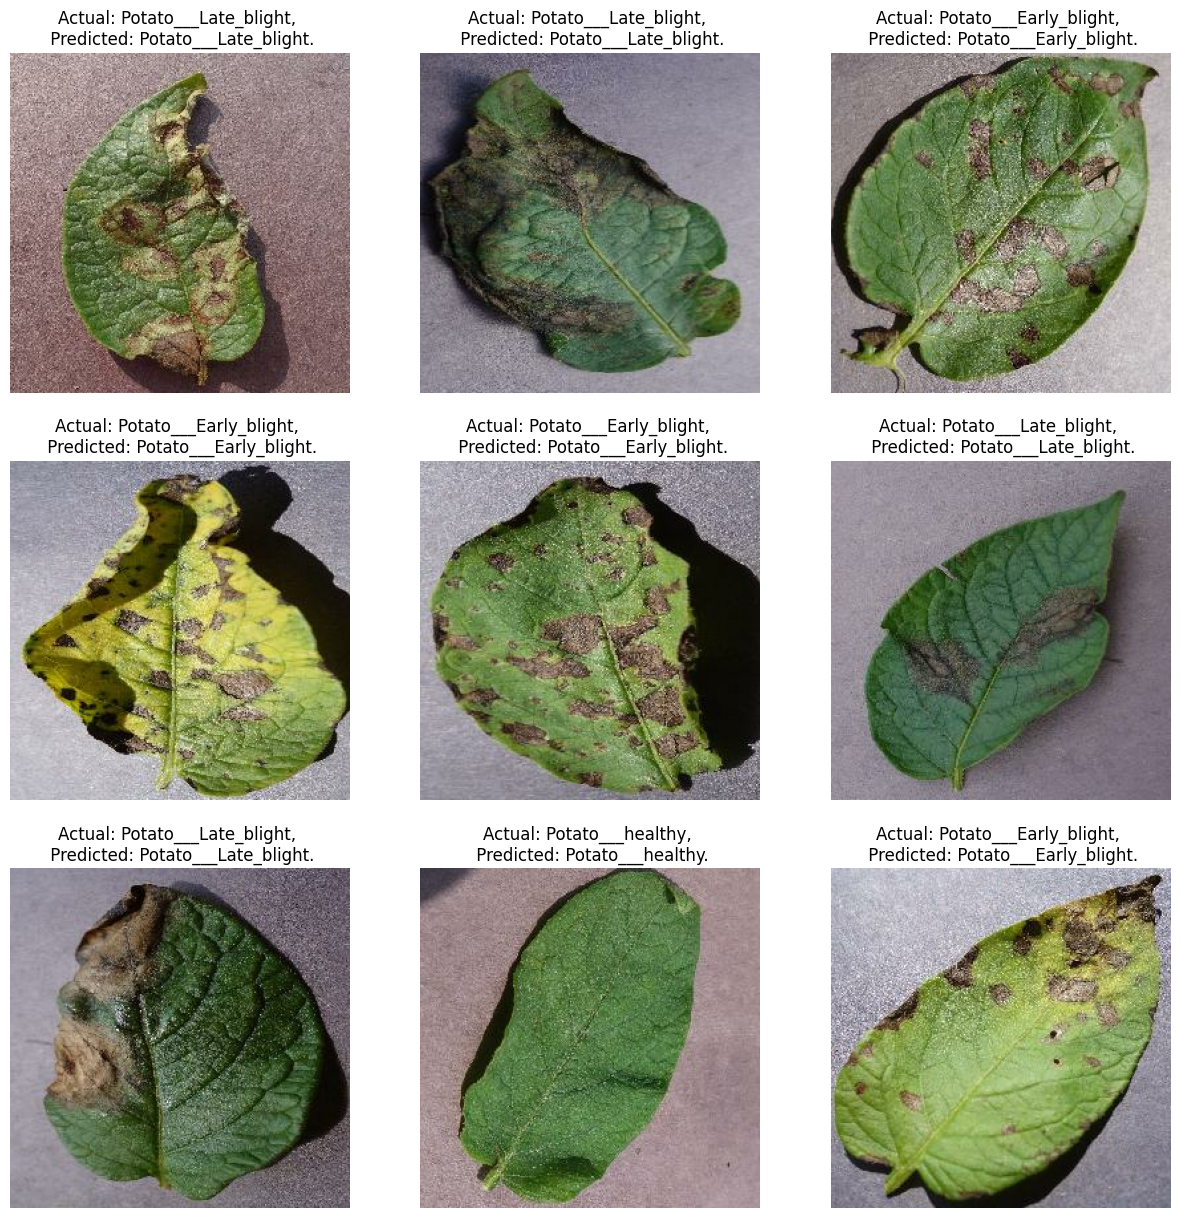

In [33]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.")
        plt.axis("off")
        

In [35]:
import os
model_version = max([int(i) for i in  os.listdir("../models")])+1

2

In [34]:
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
